# Spatial relationships and operations

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

In [2]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

In [9]:
countries.head()

iso_a3                  name      continent     pop_est  gdp_md_est  \
0    AFG           Afghanistan           Asia  34124811.0     64080.0   
1    AGO                Angola         Africa  29310273.0    189000.0   
2    ALB               Albania         Europe   3047987.0     33900.0   
3    ARE  United Arab Emirates           Asia   6072475.0    667200.0   
4    ARG             Argentina  South America  44293293.0    879400.0   

                                            geometry  
0  POLYGON ((61.21082 35.65007, 62.23065 35.27066...  
1  MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...  
2  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  
3  POLYGON ((51.57952 24.24550, 51.75744 24.29407...  
4  MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...

## Spatial relationships

An important aspect of geospatial data is that we can look at *spatial relationships*: how two spatial objects relate to each other (whether they overlap, intersect, contain, .. one another).

The topological, set-theoretic relationships in GIS are typically based on the DE-9IM model. See https://en.wikipedia.org/wiki/Spatial_relation for more information.

![](img/TopologicSpatialRelarions2.png)
(Image by [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png))

### Relationships between individual objects

Let's first create some small toy spatial objects:

A polygon <small>(note: we use `.squeeze()` here to to extract the scalar geometry object from the GeoSeries of length 1)</small>:

In [3]:
belgium = countries.loc[countries['name'] == 'Belgium', 'geometry'].squeeze()

In [5]:
type(belgium)

shapely.geometry.polygon.Polygon

Two points:

In [4]:
paris = cities.loc[cities['name'] == 'Paris', 'geometry'].squeeze()
brussels = cities.loc[cities['name'] == 'Brussels', 'geometry'].squeeze()

And a linestring:

In [6]:
from shapely.geometry import LineString
line = LineString([paris, brussels])

In [7]:
type(line)

shapely.geometry.linestring.LineString

Let's visualize those 4 geometry objects together (I only put them in a GeoSeries to easily display them together with the geopandas `.plot()` method):

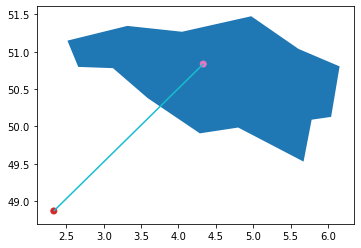

In [8]:
geopandas.GeoSeries([belgium, paris, brussels, line]).plot(cmap='tab10')

You can recognize the abstract shape of Belgium.

Brussels, the capital of Belgium, is thus located within Belgium. This is a spatial relationship, and we can test this using the individual shapely geometry objects as follow:

In [10]:
brussels.within(belgium)

True

And using the reverse, Belgium contains Brussels:

In [11]:
belgium.contains(brussels)

True

On the other hand, Paris is not located in Belgium:

In [12]:
belgium.contains(paris)

False

In [13]:
paris.within(belgium)

False

The straight line we draw from Paris to Brussels is not fully located within Belgium, but it does intersect with it:

In [14]:
belgium.contains(line)

False

In [15]:
line.intersects(belgium)

True

### Spatial relationships with GeoDataFrames

The same methods that are available on individual `shapely` geometries as we have seen above, are also available as methods on `GeoSeries` / `GeoDataFrame` objects.

For example, if we call the `contains` method on the world dataset with the `paris` point, it will do this spatial check for each country in the `world` dataframe:

In [17]:
countries.contains(paris).unique()

array([False,  True])

Because the above gives us a boolean result, we can use that to filter the dataframe:

In [18]:
countries[countries.contains(paris)]

iso_a3    name continent     pop_est  gdp_md_est  \
55    FRA  France    Europe  67106161.0   2699000.0   

                                             geometry  
55  MULTIPOLYGON (((2.51357 51.14851, 2.65842 50.7...

And indeed, France is the only country in the world in which Paris is located.

Another example, extracting the linestring of the Amazon river in South America, we can query through which countries the river flows:

In [19]:
amazon = rivers[rivers['name'] == 'Amazonas'].geometry.squeeze()

In [20]:
countries[countries.crosses(amazon)]  # or .intersects

iso_a3      name      continent      pop_est  gdp_md_est  \
22     BRA    Brazil  South America  207353391.0   3081000.0   
35     COL  Colombia  South America   47698524.0    688000.0   
124    PER      Peru  South America   31036656.0    410400.0   

                                              geometry  
22   POLYGON ((-57.62513 -30.21629, -56.29090 -28.8...  
35   POLYGON ((-66.87633 1.25336, -67.06505 1.13011...  
124  POLYGON ((-69.52968 -10.95173, -68.66508 -12.5...

<div class="alert alert-info" style="font-size:120%">

**REFERENCE**:

Overview of the different functions to check spatial relationships (*spatial predicate functions*):

* `equals`
* `contains`
* `crosses`
* `disjoint`
* `intersects`
* `overlaps`
* `touches`
* `within`
* `covers`


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.

See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations.

</div>

## Let's practice!

We will again use the Paris datasets to do some exercises. Let's start importing them again:

In [21]:
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(epsg=2154)
stations = geopandas.read_file("data/paris_bike_stations.geojson").to_crs(epsg=2154)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


<div class="alert alert-success">

**EXERCISE: The Eiffel Tower**

The Eiffel Tower is an iron lattice tower built in the 19th century, and is probably the most iconic view of Paris.

The location of the Eiffel Tower is: x of 648237.3 and y of 6862271.9.

* Create a Shapely point object with the coordinates of the Eiffel Tower and assign it to a variable called `eiffel_tower`. Print the result.
* Check if the Eiffel Tower is located within the Montparnasse district (provided).
* Check if the Montparnasse district contains the bike station location.
* Calculate the distance between the Eiffel Tower and the bike station (note: in this case, the distance is returned in meters).


<details><summary>Hints</summary>

* The `Point` class is available in the `shapely.geometry` submodule
* Creating a point can be done by passing the x and y coordinates to the `Point()` constructor.
* The `within()` method checks if the object is located within the passed geometry (used as `geometry1.within(geometry2)`).
* The `contains()` method checks if the object contains the passed geometry (used as `geometry1.contains(geometry2)`).
* To calculate the distance between two geometries, the `distance()` method of one of the geometries can be used.

</details>

</div>

In [22]:
# Import the Point geometry
from shapely.geometry import Point

In [27]:
# %load _solved/solutions/03-spatial-relationships-operations1.py
eiffel_tower = Point(648237.3, 6862271.9)
print(eiffel_tower)

POINT (648237.3 6862271.9)


In [28]:
# Accessing the Montparnasse geometry (Polygon)
district_montparnasse = districts.loc[52, 'geometry']
bike_station = stations.loc[293, 'geometry']

In [30]:
# %load _solved/solutions/03-spatial-relationships-operations3.py
eiffel_tower.within(district_montparnasse)

False

In [32]:
# %load _solved/solutions/03-spatial-relationships-operations4.py
district_montparnasse.contains(bike_station)

True

In [34]:
# %load _solved/solutions/03-spatial-relationships-operations5.py
eiffel_tower.distance(bike_station)

3540.1534488921966

<div class="alert alert-success">

**EXERCISE: In which district in the Eiffel Tower located?**

In previous exercise, we constructed a `Point` geometry for its location, and we checked that it was not located in the Montparnasse district. Let's now determine in which of the districts of Paris it *is* located.

* Create a boolean mask (or filter) indicating whether each district contains the Eiffel Tower or not. Call the result `mask`.
* Filter the `districts` dataframe with the boolean mask and print the result.


<details><summary>Hints</summary>

* To check for each polygon in the districts dataset if it contains a single point, we can use the `contains()` method of the `districts` GeoDataFrame.
* Filtering the rows of a DataFrame based on a condition can be done by passing the boolean mask into `df[..]`.

</details>

</div>

In [35]:
# Construct a point object for the Eiffel Tower
eiffel_tower = Point(648237.3, 6862271.9)

In [37]:
# %load _solved/solutions/03-spatial-relationships-operations6.py
mask = districts.contains(eiffel_tower)
mask

0     False
1     False
2     False
3     False
4     False
      ...  
75    False
76    False
77    False
78    False
79    False
Length: 80, dtype: bool

In [39]:
# %load _solved/solutions/03-spatial-relationships-operations7.py
districts[mask]

id district_name  population  \
27  28  Gros-Caillou       25156   

                                             geometry  
27  POLYGON ((649336.752 6861767.761, 649110.815 6...

<div class="alert alert-success">

**EXERCISE: How far is the closest bike station?**

Now, we might be interested in the bike stations nearby the Eiffel Tower. To explore them, let's visualize the Eiffel Tower itself as well as the bikes stations within 1km.

To do this, we can calculate the distance to the Eiffel Tower for each of the stations. Based on this result, we can then create a mask that takes `True` if the station is within 1km, and `False` otherwise, and use it to filter the stations GeoDataFrame. Finally, we make a visualization of this subset.

* Calculate the distance to the Eiffel Tower for each station, and call the result `dist_eiffel`.
* Print the distance to the closest station (which is the minimum of `dist_eiffel`).
* Select the rows the `stations` GeoDataFrame where the distance to the Eiffel Tower is less than 1 km (note that the distance is in meters). Call the result `stations_eiffel`.

<details><summary>Hints</summary>

* The `distance()` method of a GeoDataFrame works element-wise: it calculates the distance between each geometry in the GeoDataFrame and the geometry passed to the method.
* A Series has a `min()` method to calculate the minimum value.
* To create a boolean mask based on a condition, we can do e.g. `s < 100`.

</details>

</div>

In [42]:
# %load _solved/solutions/03-spatial-relationships-operations8.py
dist_eiffel = stations.distance(eiffel_tower)
dist_eiffel

0        3343.212509
1        8260.688451
2        8126.514622
3       10482.807156
4       10176.957110
            ...     
1221     6636.204309
1222     6153.437794
1223     2709.390547
1224     3633.146997
1225     2420.249246
Length: 1226, dtype: float64

In [44]:
# %load _solved/solutions/03-spatial-relationships-operations9.py
dist_eiffel.min()

232.34672323449053

In [46]:
# %load _solved/solutions/03-spatial-relationships-operations10.py
stations_eiffel = stations[dist_eiffel < 1000]

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


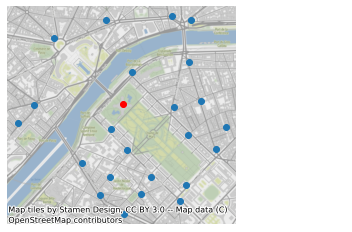

In [47]:
# Make a plot of the close-by restaurants
ax = stations_eiffel.to_crs(epsg=3857).plot()
geopandas.GeoSeries([eiffel_tower], crs='EPSG:2154').to_crs(epsg=3857).plot(ax=ax, color='red')
import contextily
contextily.add_basemap(ax)
ax.set_axis_off()

## Spatial operations

Next to the spatial predicates that return boolean values, Shapely and GeoPandas also provide operations that return new geometric objects.

**Binary operations:**

<table><tr>
<td> <img src="img/spatial-operations-base.png"/> </td>
<td> <img src="img/spatial-operations-intersection.png"/> </td>
</tr>
<tr>
<td> <img src="img/spatial-operations-union.png"/> </td>
<td> <img src="img/spatial-operations-difference.png"/> </td>
</tr></table>

**Buffer:**

<table><tr>
<td> <img src="img/spatial-operations-buffer-point1.png"/> </td>
<td> <img src="img/spatial-operations-buffer-point2.png"/> </td>
</tr>
<tr>
<td> <img src="img/spatial-operations-buffer-line.png"/> </td>
<td> <img src="img/spatial-operations-buffer-polygon.png"/> </td>
</tr></table>


See https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods for more details.

For example, using the toy data from above, let's construct a buffer around Brussels (which returns a Polygon):

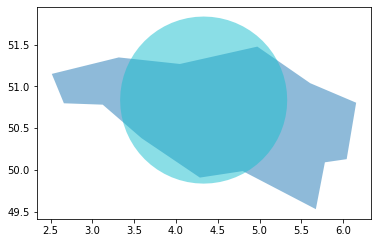

In [48]:
geopandas.GeoSeries([belgium, brussels.buffer(1)]).plot(alpha=0.5, cmap='tab10')

and now take the intersection, union or difference of those two polygons:

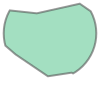

In [49]:
brussels.buffer(1).intersection(belgium)

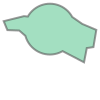

In [50]:
brussels.buffer(1).union(belgium)

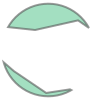

In [51]:
brussels.buffer(1).difference(belgium)

Another useful method is the `unary_union` attribute, which converts the set of geometry objects in a GeoDataFrame into a single geometry object by taking the union of all those geometries.

For example, we can construct a single object for the Africa continent:

In [52]:
africa_countries = countries[countries['continent'] == 'Africa']

In [53]:
africa = africa_countries.unary_union

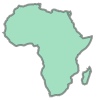

In [54]:
africa

In [55]:
print(str(africa)[:1000])

MULTIPOLYGON (((49.54351891459575 -12.46983285894055, 49.80898074727909 -12.89528492599955, 50.05651085795716 -13.55576140712198, 50.21743126811407 -14.7587887508768, 50.47653689962553 -15.22651213955054, 50.37711144389596 -15.70606943121913, 50.20027469259318 -16.00026336025677, 49.86060550313868 -15.41425261806692, 49.67260664246086 -15.71020354580248, 49.86334435405016 -16.45103687913878, 49.77456424337271 -16.8750420060936, 49.49861209493412 -17.10603565843827, 49.43561852397031 -17.95306406013437, 49.04179243347394 -19.11878101977445, 48.54854088724801 -20.49688811613413, 47.93074913919867 -22.39150115325108, 47.54772342305131 -23.78195891692852, 47.0957613462266 -24.94162973399045, 46.28247765481709 -25.17846282318411, 45.40950768411045 -25.60143442149309, 44.83357384621755 -25.34610116953894, 44.03972049334976 -24.98834522878231, 43.76376834491117 -24.46067717864999, 43.69777754087445 -23.5741163062506, 43.34565433123763 -22.77690398528387, 43.254187046081 -22.05741301848412, 43

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**:

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.


* An overview of all methods provided by GeoPandas can be found here: http://geopandas.readthedocs.io/en/latest/reference.html


</div>



## Let's practice!

<div class="alert alert-success">
 <b>EXERCISE: What are the districts close to the Seine?</b>
 
 <p>
 Below, the coordinates for the Seine river in the neighbourhood of Paris are provided as a GeoJSON-like feature dictionary (created at http://geojson.io). 
 </p>
 
  <p>
 Based on this `seine` object, we want to know which districts are located close (maximum 150 m) to the Seine. 
 </p>
 
 
 <p>
 <ul>
  <li>Create a buffer of 150 m around the Seine.</li>
  <li>Check which districts intersect with this buffered object.</li>
  <li>Make a visualization of the districts indicating which districts are located close to the Seine.</li>
 </ul> 
 </p>
 
</div>

In [56]:
districts = geopandas.read_file("data/paris_districts.geojson").to_crs(epsg=2154)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [57]:
# created a line with http://geojson.io
s_seine = geopandas.GeoDataFrame.from_features({"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"LineString","coordinates":[[2.408924102783203,48.805619828930226],[2.4092674255371094,48.81703747481909],[2.3927879333496094,48.82325391133874],[2.360687255859375,48.84912860497674],[2.338714599609375,48.85827758964043],[2.318115234375,48.8641501307046],[2.298717498779297,48.863246707697],[2.2913360595703125,48.859519915404825],[2.2594070434570312,48.8311646245967],[2.2436141967773438,48.82325391133874],[2.236919403076172,48.82347994904826],[2.227306365966797,48.828339513221444],[2.2224998474121094,48.83862215329593],[2.2254180908203125,48.84856379804802],[2.2240447998046875,48.85409863123821],[2.230224609375,48.867989496547864],[2.260265350341797,48.89192242750887],[2.300262451171875,48.910203080780285]]}}]},
                                               crs={'init': 'epsg:4326'})

In [58]:
# convert to local UTM zone
s_seine_utm = s_seine.to_crs(epsg=2154)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


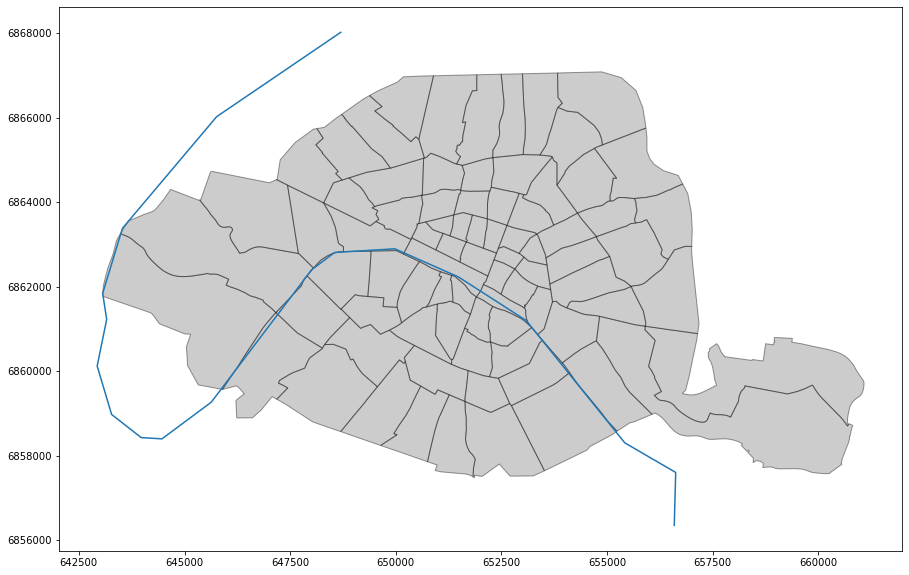

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
districts.plot(ax=ax, color='grey', alpha=0.4, edgecolor='k')
s_seine_utm.plot(ax=ax)

In [60]:
# access the single geometry object
seine = s_seine_utm.geometry.squeeze()

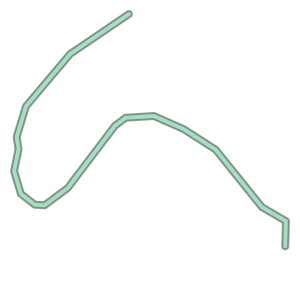

In [64]:
# %load _solved/solutions/03-spatial-relationships-operations11.py
seine_buffer = seine.buffer(150)
seine_buffer

In [66]:
# %load _solved/solutions/03-spatial-relationships-operations13.py
districts_seine = districts[districts.intersects(seine_buffer)]

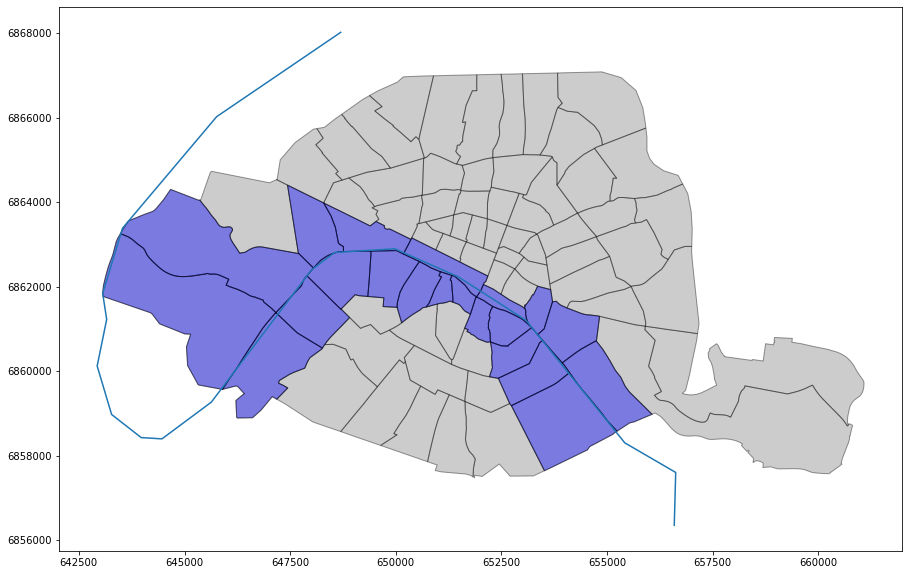

In [68]:
# %load _solved/solutions/03-spatial-relationships-operations14.py
fig, ax = plt.subplots(figsize=(20, 10))
districts.plot(ax=ax, color='grey', alpha=0.4, edgecolor='k')
districts_seine.plot(ax=ax, color='blue', alpha=0.4, edgecolor='k')
s_seine_utm.plot(ax=ax)